<a href="https://colab.research.google.com/github/mlabonne/chessllm/blob/main/Chess_LLM_Arena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BlueSunflower/Pythia-160M-chess wins!
ELO change:
* mlabonne/chesspythia-70m: 1000 -> 985 (-15)
* BlueSunflower/Pythia-160M-chess: 1023 -> 1038 (+15)


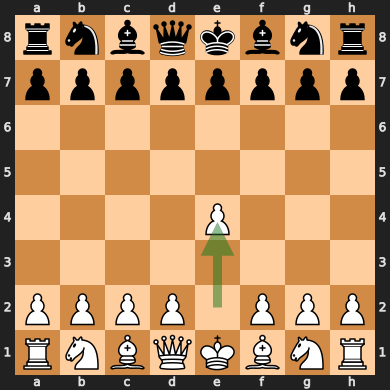

In [2]:
# @title # ♟️ Chess LLM Arena
# @markdown https://gist.github.com/chessllm
# Based on a script made by 903124: https://gist.github.com/903124/cfbefa24da95e2316e0d5e8ef8ed360d
# See in Outlines: https://outlines-dev.github.io/outlines/cookbook/models_playing_chess/

!pip install -qqq python-chess outlines datasets cairosvg gistyc --progress-bar off

import io
import os
import re
import time
from collections import defaultdict
from datetime import datetime

import cairosvg
import chess
import chess.svg
import gistyc
import numpy as np
import outlines.models as models
import outlines.text.generate as generate
import pandas as pd
import requests
from google.colab import userdata
from IPython.display import Image as IPythonImage
from IPython.display import clear_output, update_display
from PIL import Image as PILImage


# Generate regular expression for legal moves
def generate_regex(board):
    legal_moves = list(board.legal_moves)
    move_strings = [board.san(move) for move in legal_moves]
    move_strings = [re.sub(r"[+#]", "", move) for move in move_strings]
    regex_pattern = "|".join(re.escape(move) for move in move_strings)
    return regex_pattern


def write_pgn(
    pgn_moves, model_id_white, model_id_black, result, time_budget, termination
):
    # Get current UTC date and time
    current_utc_datetime = datetime.utcnow()
    utc_date = current_utc_datetime.strftime("%Y.%m.%d")
    utc_time = current_utc_datetime.strftime("%H:%M:%S")

    # Output the final PGN with CLKS and additional details
    final_pgn = f"""
[Event 'Chess LLM Arena']
[Site 'https://github.com/mlabonne/chessllm']
[Date '{utc_date}']
[White '{model_id_white}']
[Black '{model_id_black}']
[Result '{result}']
[Time '{utc_time}']
[TimeControl '{time_budget}+0']
[Termination '{termination}']

{pgn_moves}
"""

    return final_pgn


def determine_termination(board, time_budget_white, time_budget_black):
    if board.is_checkmate():
        return "Checkmate"
    elif board.is_stalemate():
        return "Stalemate"
    elif board.is_insufficient_material():
        return "Draw due to insufficient material"
    elif board.can_claim_threefold_repetition():
        return "Draw by threefold repetition"
    elif board.can_claim_fifty_moves():
        return "Draw by fifty-move rule"
    elif time_budget_white <= 0 or time_budget_black <= 0:
        return "Timeout"
    else:
        return "Unknown"


def create_gif(image_list, gif_path, duration):
    # Convert numpy arrays back to PIL images
    pil_images = [PILImage.fromarray(image) for image in image_list]

    # Save the images as a GIF
    pil_images[0].save(
        gif_path, save_all=True, append_images=pil_images[1:], duration=duration, loop=0
    )


def save_result_file(
    pgn_id, model_id_white, model_id_black, result, auth_token, gist_id
):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Data to be written to the file
    data_str = f"{pgn_id},{timestamp},{model_id_white},{model_id_black},{result}\n"

    # Append data to a text file
    with open("chessllm_results.csv", "a") as file:
        file.write(data_str)

    # Update the Gist
    gist_api = gistyc.GISTyc(auth_token=GITHUB_TOKEN)
    response_update_data = gist_api.update_gist(
        file_name="chessllm_results.csv", gist_id=gist_id
    )


def save_pgn(final_pgn, file_name, auth_token):
    # Write final PGN to a file
    with open(file_name + ".pgn", "w") as file:
        file.write(final_pgn)

    gist_api = gistyc.GISTyc(auth_token=GITHUB_TOKEN)
    response_data = gist_api.create_gist(file_name=file_name + ".pgn")

    return response_data["id"]


def download_file(base_url, file_name):
    # Unique query parameter to bypass cache (using a timestamp)
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    url = f"{base_url}?ts={timestamp}"

    headers = {
        "Cache-Control": "no-cache, no-store, must-revalidate",
        "Pragma": "no-cache",
        "Expires": "0",
    }

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        with open(file_name, "wb") as file:
            file.write(response.content)
    else:
        print(f"Failed to download file. HTTP status code: {response.status_code}")


def calculate_elo(rank1, rank2, result):
    """
    Calculate the new ELO rating for a player.
    :param rank1: The current ELO rating of player 1
    :param rank2: The current ELO rating of player 2
    :param result: 1 if player 1 wins, 0 if player 2 wins, 0.5 for a draw
    :return: The updated ELO rating of player 1
    """
    K = 32
    expected_score1 = 1 / (1 + 10 ** ((rank2 - rank1) / 400))
    new_rank1 = rank1 + K * (result - expected_score1)
    return round(new_rank1)


def update_elo_ratings(chess_data):
    """
    Update ELO ratings for each player based on the match results in the dataset.
    :param chess_data: DataFrame with chess match results
    :return: A dictionary with updated ELO ratings for each player
    """
    elo_ratings = defaultdict(lambda: 1000)  # Default ELO rating is 1000

    for index, row in chess_data.iterrows():
        if row["Result"] == "*":
            continue  # Skip ongoing games

        model1 = row["Model1"]
        model2 = row["Model2"]
        result = row["Result"]

        model1_elo = elo_ratings[model1]
        model2_elo = elo_ratings[model2]

        # Update ELO based on the result
        if result == "1-0":  # Model1 wins
            elo_ratings[model1] = calculate_elo(model1_elo, model2_elo, 1)
            elo_ratings[model2] = calculate_elo(model2_elo, model1_elo, 0)
        elif result == "0-1":  # Model2 wins
            elo_ratings[model1] = calculate_elo(model1_elo, model2_elo, 0)
            elo_ratings[model2] = calculate_elo(model2_elo, model1_elo, 1)
        elif result == "1/2-1/2":  # Draw
            elo_ratings[model1] = calculate_elo(model1_elo, model2_elo, 0.5)
            elo_ratings[model2] = calculate_elo(model2_elo, model1_elo, 0.5)

    return elo_ratings


os.environ["TOKENIZERS_PARALLELISM"] = "false"
GITHUB_TOKEN = userdata.get("chessllm")
RESULT_GIST_ID = "c491299e7b8a45a61ce5403a70cf8656"
LEAD_GIST_ID = "696115fe2df47fb2350fcff2663678c9"

# Initialize model
# @markdown ## Models
model_id_white = "mlabonne/chesspythia-70m"  # @param {type: "string"}
model_id_black = "BlueSunflower/Pythia-160M-chess"  # @param {type: "string"}
model_white = models.transformers(model_id_white)
model_black = models.transformers(model_id_black)

# @markdown ## Parameters
TIME_BUDGET = 120  # @param {type: "number"} # 60 = 1 minute
prompt = '1.'  # @param {type: "string"}

# Initialize the chess board
board = chess.Board()
board_images = []
pgn_moves = ""
move_number = 1
result = None
time_budget_white = TIME_BUDGET
time_budget_black = TIME_BUDGET

# Download results
url1 = (
    f"https://gist.githubusercontent.com/chessllm/{RESULT_GIST_ID}/raw"
)
download_file(url1, "chessllm_results.csv")

# Load ELO ratings for each model
url2 = f"https://gist.githubusercontent.com/chessllm/{LEAD_GIST_ID}/raw"
download_file(url2, "chessllm_leaderboard.csv")
elo_ratings_df = pd.read_csv("chessllm_leaderboard.csv")
clear_output(wait=True)

# Game loop
while not board.is_game_over():
    start_time = time.time()

    # Generate move
    regex_pattern = generate_regex(board)
    current_model = model_white if board.turn == chess.WHITE else model_black
    guided = generate.regex(current_model, regex_pattern, max_tokens=10)(prompt)

    try:
        # Parse move
        move_san = guided.strip()
        move = board.parse_san(move_san)
        if move not in board.legal_moves:
            print(f"Illegal move: {move_san}")
            break
        board.push(move)

        # Write move
        if board.turn == chess.BLACK:
            move_str = f"{move_number}. {move_san} "
            move_number += 1
        else:
            move_str = f"{move_san} "
        pgn_moves += move_str

        # Render the board to an image
        last_move = board.peek()  # Get the last move made
        svg = chess.svg.board(
            board=board, arrows=[(last_move.from_square, last_move.to_square)]
        ).encode("utf-8")
        png = cairosvg.svg2png(bytestring=svg)
        image = PILImage.open(io.BytesIO(png))
        board_images.append(np.array(image))

        # Display board
        update_display(image, display_id="chess_board")

        # Update time budget
        end_time = time.time()
        move_duration = end_time - start_time

        # Deduct the time taken for the move from the model's time budget
        if board.turn == chess.WHITE:
            time_budget_black -= move_duration
            if time_budget_black <= 0:
                result = "1-0"
                break
        else:
            time_budget_white -= move_duration
            if time_budget_white <= 0:
                result = "0-1"
                break

        print(f"White time left: {time_budget_white:.2f}s")
        print(f"Black time left: {time_budget_black:.2f}s")
        clear_output(wait=True)

    except ValueError:
        print(f"Invalid move: {guided}")
        break

# Get result
if result is None:
    result = board.result()

# Create PGN
termination = determine_termination(board, time_budget_white, time_budget_black)
final_pgn = write_pgn(
    pgn_moves, model_id_white, model_id_black, result, TIME_BUDGET, termination
)
file_name = f"{model_id_white.split('/')[-1]}_vs_{model_id_black.split('/')[-1]}"
pgn_id = save_pgn(final_pgn, file_name, GITHUB_TOKEN)

# Save results
save_result_file(
    pgn_id, model_id_white, model_id_black, result, GITHUB_TOKEN, RESULT_GIST_ID
)

# Create and display the GIF
clear_output(wait=True)
create_gif(board_images, file_name + ".gif", duration=400)

# Print ELO ratings
current_elo_white = elo_ratings_df.loc[
    elo_ratings_df["Model"] == model_id_white, "ELO Rating"
].get(0, 1000)
current_elo_black = elo_ratings_df.loc[
    elo_ratings_df["Model"] == model_id_black, "ELO Rating"
].get(0, 1000)

if result == "1-0":
    new_elo_white = calculate_elo(current_elo_white, current_elo_black, 1)
    new_elo_black = calculate_elo(current_elo_black, current_elo_white, 0)
    print(f"{model_id_white} wins!")
    print("ELO change:")
    print(
        f"* {model_id_white}: {current_elo_white} -> {new_elo_white} ({new_elo_white - current_elo_white:+})"
    )
    print(
        f"* {model_id_black}: {current_elo_black} -> {new_elo_black} ({new_elo_black - current_elo_black:+})"
    )
elif result == "0-1":
    new_elo_white = calculate_elo(current_elo_white, current_elo_black, 0)
    new_elo_black = calculate_elo(current_elo_black, current_elo_white, 1)
    print(f"{model_id_black} wins!")
    print("ELO change:")
    print(
        f"* {model_id_white}: {current_elo_white} -> {new_elo_white} ({new_elo_white - current_elo_white:+})"
    )
    print(
        f"* {model_id_black}: {current_elo_black} -> {new_elo_black} ({new_elo_black - current_elo_black:+})"
    )
elif result == "1/2-1/2":
    new_elo_white = calculate_elo(current_elo_white, current_elo_black, 0.5)
    new_elo_black = calculate_elo(current_elo_black, current_elo_white, 0.5)
    print("Draw!")
    print("ELO change:")
    print(
        f"* {model_id_white}: {current_elo_white} -> {new_elo_white} ({new_elo_white - current_elo_white:+})"
    )
    print(
        f"* {model_id_black}: {current_elo_black} -> {new_elo_black} ({new_elo_black - current_elo_black:+})"
    )
elif result == "*":
    print("Ongoing game!")

IPythonImage(filename=file_name + ".gif")

In [3]:
# Update ELO ratings for each model
chess_data = pd.read_csv('chessllm_results.csv')
elo_ratings = update_elo_ratings(chess_data)

# Convert the dictionary to a DataFrame for better display
elo_ratings_df = pd.DataFrame(elo_ratings.items(), columns=['Model', 'ELO Rating'])

# Round the ELO ratings to the nearest integer
elo_ratings_df['ELO Rating'] = elo_ratings_df['ELO Rating'].round().astype(int)

elo_ratings_df.sort_values(by='ELO Rating', ascending=False, inplace=True)
elo_ratings_df.reset_index(drop=True, inplace=True)
elo_ratings_df.to_csv('chessllm_leaderboard.csv', index=False)

# Upload chessllm_leaderboard.csv to GIST
gist_api = gistyc.GISTyc(auth_token=GITHUB_TOKEN)
response_update_data = gist_api.update_gist(file_name='chessllm_leaderboard.csv', gist_id={LEAD_GIST_ID})

elo_ratings_df

,Model,ELO Rating
0,BlueSunflower/Pythia-160M-chess,1039
1,mlabonne/chesspythia-70m,1002
2,EleutherAI/pythia-70m,959
